In [23]:
import warnings; warnings.simplefilter('ignore')

import os
import time
import torch
import random
import itertools
import umap
import scipy as sp
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from cell import graph_utils, utils, plot_utils, analysis
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarGraph
from torch.nn import functional as F
from stellargraph.data import BiasedRandomWalk
import cell.BiasedDirectedWeightedWalk as BDWW
from stellargraph import StellarDiGraph
import seaborn as sns
from IPython.display import Image
from cell import coupled_wv as cp
import cell.math_utils as mu
from sklearn.manifold import TSNE


os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
### Read all the layers interactions

In [3]:
colors = utils.read_visp_npp_cldf()['cluster_color'].tolist()
types = utils.read_visp_npp_cldf()['cluster_label'].tolist()
layers = utils.get_npp_visp_layers()
total_inter = np.zeros((93,93))

for layer in layers:
    path = utils.get_npp_visp_interaction_mat_path(layer)
    tmp_inter= pd.read_csv(path, index_col="Unnamed: 0")
    total_inter = total_inter + tmp_inter.values

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv
Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


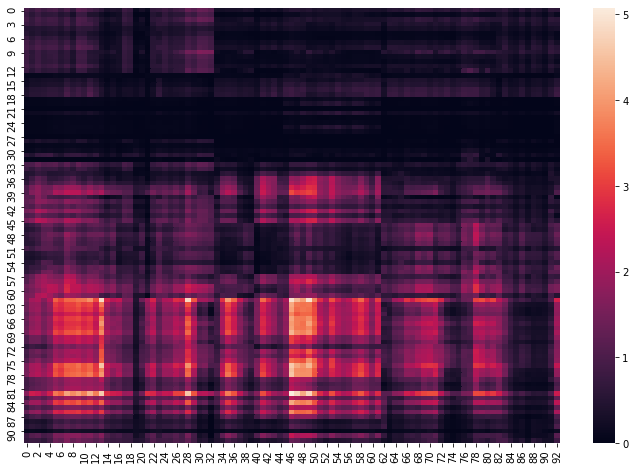

In [4]:
adj = total_inter.astype(float)
fig = plt.figure(figsize=(12,8))
sns.heatmap(adj)

In [5]:
maxval = np.max(adj)

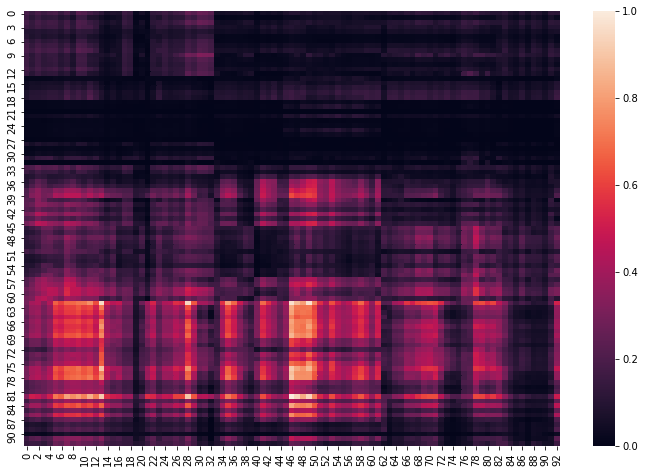

In [6]:
# adj = adj/adj.sum(axis=1)[:,None]
adj = adj/maxval
fig = plt.figure(figsize=(12,8))
sns.heatmap(adj)

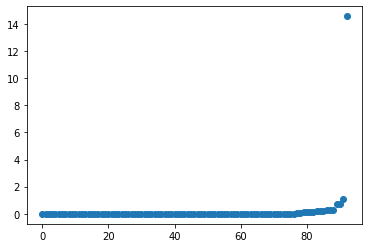

In [7]:
adj = np.nan_to_num(adj)
w, v = sp.linalg.eig(adj)
plt.scatter([i for i in range(len(w))], np.sort(np.abs(w)))

In [8]:
1/abs(w)[0]

0.0686371309665294

## Evaluation
#### Node_Averaged_Normalized_Discounted_Cumulative_Gain (nandcg) as a function of NMF components

Text(0, 0.5, 'nandcg@10')

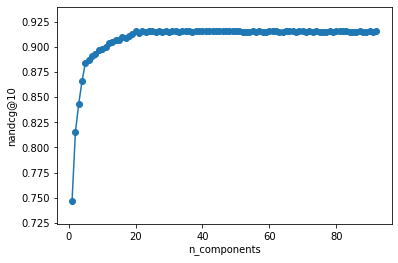

In [9]:
Katz = analysis.Katz_proximity(adj, beta = 0.05)

nandcg = []
for n in range(1, 93):
    U_s, U_t = analysis.nmf_factorization(Katz, n_components=n)
    s_to_t, t_to_s = analysis.return_right_left_similarity(U_s, U_t)
    nandcg.append(analysis.nandcg_score_at_k(s_to_t, adj, k=10))
    
plt.scatter(range(1,93),nandcg)
plt.plot(range(1,93),nandcg)
plt.xlabel("n_components")
plt.ylabel("nandcg@10")

In [10]:
s_to_t, t_to_s = analysis.return_right_left_similarity(U_s, U_t)
for n in range(91):
    sorted_similarity_index_of_n = np.argsort(-s_to_t[n])
    predicted_scores = np.array([s_to_t[n][sorted_similarity_index_of_n]])
    true_relevance = np.array([adj[n][sorted_similarity_index_of_n]])
    break

In [22]:
np.log2(-10)

nan

In [21]:
np.linalg.norm(U_s[0])

0.25785580275591335

Text(0, 0.5, 'nandcg@93')

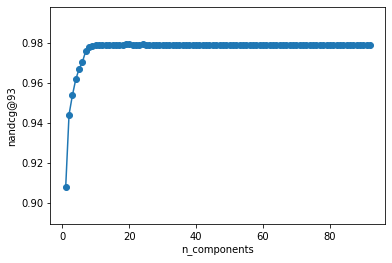

In [49]:
Katz = analysis.Katz_proximity(adj, beta = 0.5)

nandcg = []
for n in range(1, 93):
    U_s, U_t = analysis.nmf_factorization(Katz, n_components=n)
    s_to_t, t_to_s = analysis.return_right_left_similarity(U_s, U_t)
    nandcg.append(analysis.nandcg_score_at_k(s_to_t, adj))
    
plt.scatter(range(1,93),nandcg)
plt.plot(range(1,93),nandcg)
plt.xlabel("n_components")
plt.ylabel("nandcg@93")

#### nandcg@k, Katz_n_components are fixed at 20

Text(0, 0.5, 'nandcg@k')

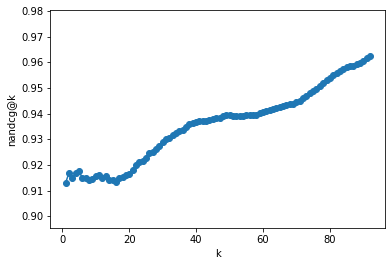

In [11]:
U_s, U_t = analysis.nmf_factorization(Katz, n_components=20)
nandcg = []

for k in range(1, 93):
    s_to_t, t_to_s = analysis.return_right_left_similarity(U_s, U_t)
    nandcg.append(analysis.nandcg_score_at_k(s_to_t, adj, k=k))
    
plt.scatter(range(1,93),nandcg)
plt.plot(range(1,93),nandcg)
plt.xlabel("k")
plt.ylabel("nandcg@k")

### NRMSE as a function of NMF components

Text(0, 0.5, 'NMRSE')

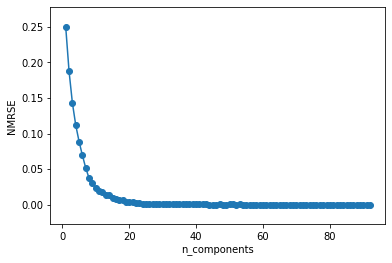

In [51]:
Katz = analysis.Katz_proximity(adj, beta = 0.5)

nrmse = []
for n in range(1, 93):
    U_s, U_t = analysis.nmf_factorization(Katz, n_components=n)
    nrmse.append(analysis.NRMSE(Katz, U_s, U_t))
    
plt.scatter(range(1,93),nrmse)
plt.plot(range(1,93),nrmse)
plt.xlabel("n_components")
plt.ylabel("NMRSE")

# Plot Emitter Receiver representation

In [25]:
Katz = analysis.Katz_proximity(adj, beta = 0.05)
U_s, U_t = analysis.nmf_factorization(Katz, n_components=20)
s_to_t, t_to_s = analysis.return_right_left_similarity(U_s, U_t)
theta = graph_utils.return_theta(93)

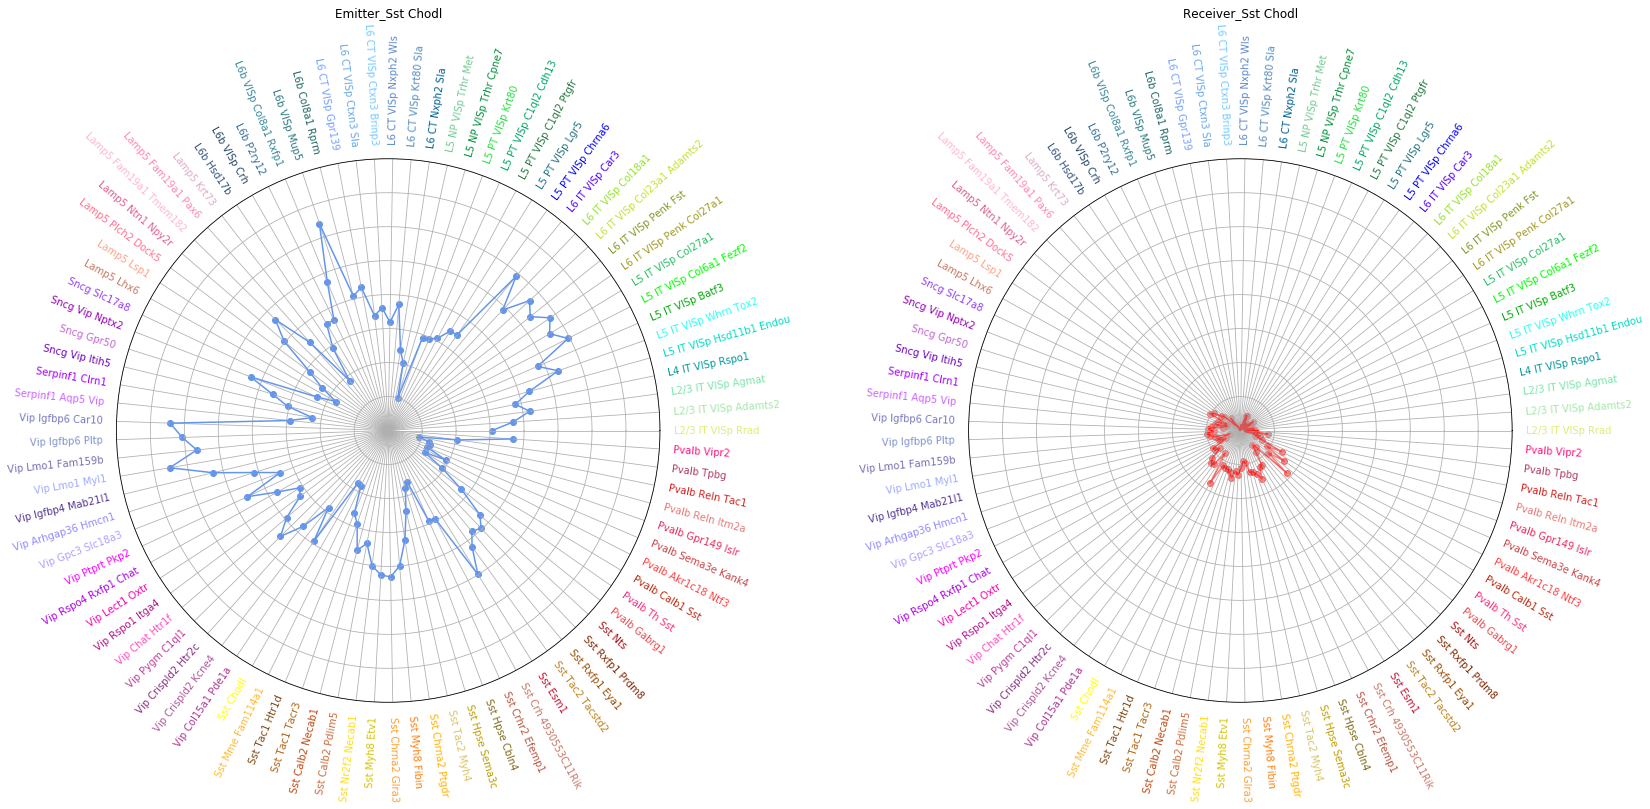

In [28]:
for i in [62]:
    fig = plot_utils.plot_polar_source_target_relation(theta, 
                                                       r1=s_to_t[i], 
                                                       r2=t_to_s[i], 
                                                       title=types[i],
                                                       rmax = 0.2,
#                                                        rmax = 0.035,
                                                       xtick_label_colors=colors, 
                                                       xtick_labels=types,
                                                       plot_size=(28, 10))
    
#     figname = types[i].replace("/", "")
#     figname = figname.replace(" ", "_") 
#     fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/dat/fig/" + figname + "_normal.png", 
#                 dpi=300, bbox_inches='tight')

### Dimensionality reduction with UMAP

In [16]:
emb = np.concatenate((s_to_t,t_to_s),axis=1)
Scaled_emb = StandardScaler().fit_transform(emb)
reducer = umap.UMAP(random_state=40)
Katz_umap = reducer.fit_transform(Scaled_emb)

In [17]:
Katz_umap = pd.DataFrame(Katz_umap, columns=['Z0', "Z1"])
Katz_umap['cluster_color'] = colors

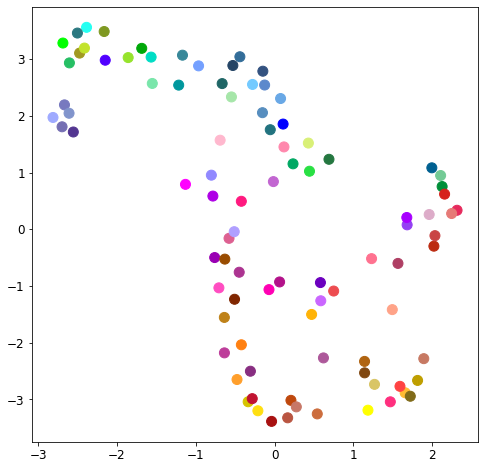

In [18]:
fig = plot_utils.plot_embedding(Katz_umap, plot_dim=2, annotation=False, plot_size=(8,8), scatter_point_size=100)

In [19]:
npp_norm_dat = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/FACs_norm_csv_npp_genes.csv", index_col='Unnamed: 0')
labels = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/FACs_correct_labels.csv", index_col="Unnamed: 0")

In [20]:
npp_norm_dat = npp_norm_dat.T

In [21]:
df = npp_norm_dat.join(labels["cl"], how='outer')

In [22]:
df = df.groupby(by="cl").mean().loc[types]
df = df.fillna(0)

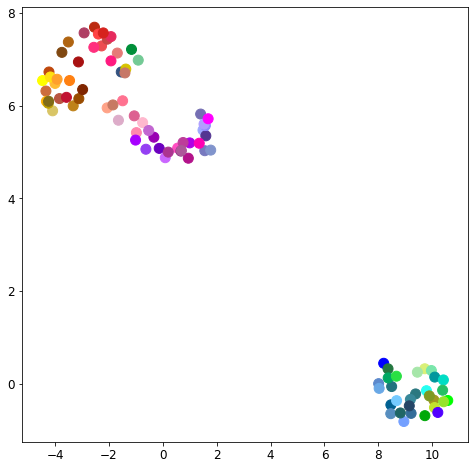

In [23]:
Scaled_df = StandardScaler().fit_transform(df.values)
reducer = umap.UMAP(random_state=40)
exp_umap = reducer.fit_transform(Scaled_df)

exp_umap = pd.DataFrame(exp_umap, columns=['Z0', "Z1"])
exp_umap['cluster_color'] = colors

fig = plot_utils.plot_embedding(exp_umap, plot_dim=2, annotation=False, plot_size=(8,8), scatter_point_size=100)

In [24]:
Katz_umap_aligned, exp_umap_aligned, disparity = analysis.procrustes(
     np.array(Katz_umap[["Z0", "Z1"]]), np.array(exp_umap[["Z0", "Z1"]]))
disparity

0.44078274864999795

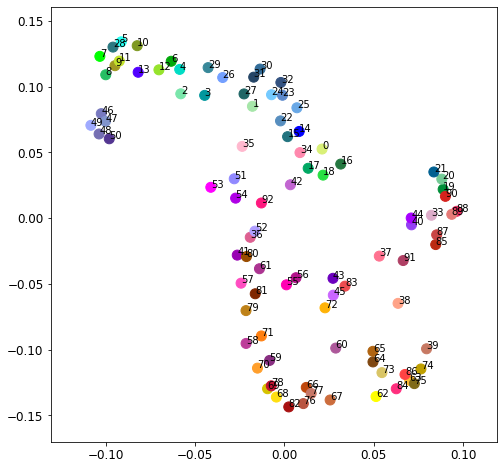

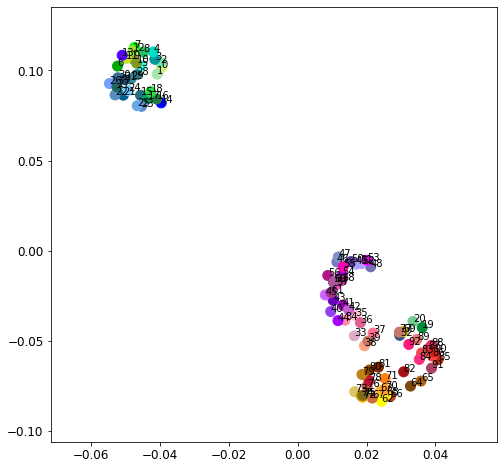

In [44]:
Katz_umap_aligned = pd.DataFrame(Katz_umap_aligned, columns=['Z0', "Z1"])
Katz_umap_aligned['cluster_color'] = colors

fig = plot_utils.plot_embedding(Katz_umap_aligned, plot_dim=2, annotation=True, plot_size=(8,8), scatter_point_size=100)

exp_umap_aligned = pd.DataFrame(exp_umap_aligned, columns=['Z0', "Z1"])
exp_umap_aligned['cluster_color'] = colors

fig = plot_utils.plot_embedding(exp_umap_aligned, plot_dim=2, annotation=True, plot_size=(8,8), scatter_point_size=100)

In [66]:
types[35]

'Lamp5 Fam19a1 Tmem182'

### Compute the distance of each node from the rest of the nodes in each emb
### Fit a linear line and compute R_squared

In [26]:
dist1 = analysis.pairwise_ucleadian_dist_between_rows(np.array(Katz_umap_aligned[["Z0", "Z1"]]).astype(float))
dist2 = analysis.pairwise_ucleadian_dist_between_rows(np.array(exp_umap_aligned[["Z0", "Z1"]]).astype(float))

In [27]:
r2 = []
for i in range(93):
    xs = dist1[i]
    ys = dist2[i]
    m, b = analysis.best_fit_slope_and_intercept(xs,ys)
    regression_line = [(m*x)+b for x in xs]

    r_squared = analysis.coefficient_of_determination(ys,regression_line)
    r2.append(r_squared)

#     plt.scatter(xs,ys,color='#003F72',label='data')
#     plt.plot(xs, regression_line, label='regression line')
#     plt.legend(loc=4)
#     plt.show()
    

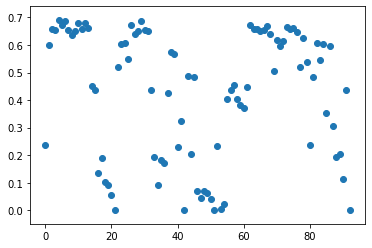

In [28]:
plt.scatter(range(93), r2)

In [29]:
np.argsort(np.array(r2))

array([42, 21, 92, 51, 53, 54, 50, 47, 20, 49, 46, 48, 34, 19, 18, 90, 16,
       36, 35, 17, 33, 88, 44, 89, 40, 52, 80,  0, 87, 41, 85, 60, 59, 55,
       58, 37, 15, 56, 91, 32, 61, 14, 57, 45, 81, 43, 69, 22, 77, 79, 83,
       25, 39, 38, 86, 71,  1, 84, 23, 24, 82, 72, 70, 78,  8, 68, 27, 76,
        9, 65, 31, 28,  7, 30,  3, 66,  2, 63, 74, 64, 11, 13, 75, 73, 67,
        5, 62, 26, 12, 10, 29,  6,  4])

'L6 CT Nxph2 Sla'

In [58]:
node = 34
print(analysis.get_closest_nodes(Katz_umap_aligned[["Z0", "Z1"]], range(93), node, 4))
print(analysis.get_closest_nodes(exp_umap_aligned[["Z0", "Z1"]], range(93), node, 4))

[0, 17, 15, 14]
[44, 35, 36, 42]


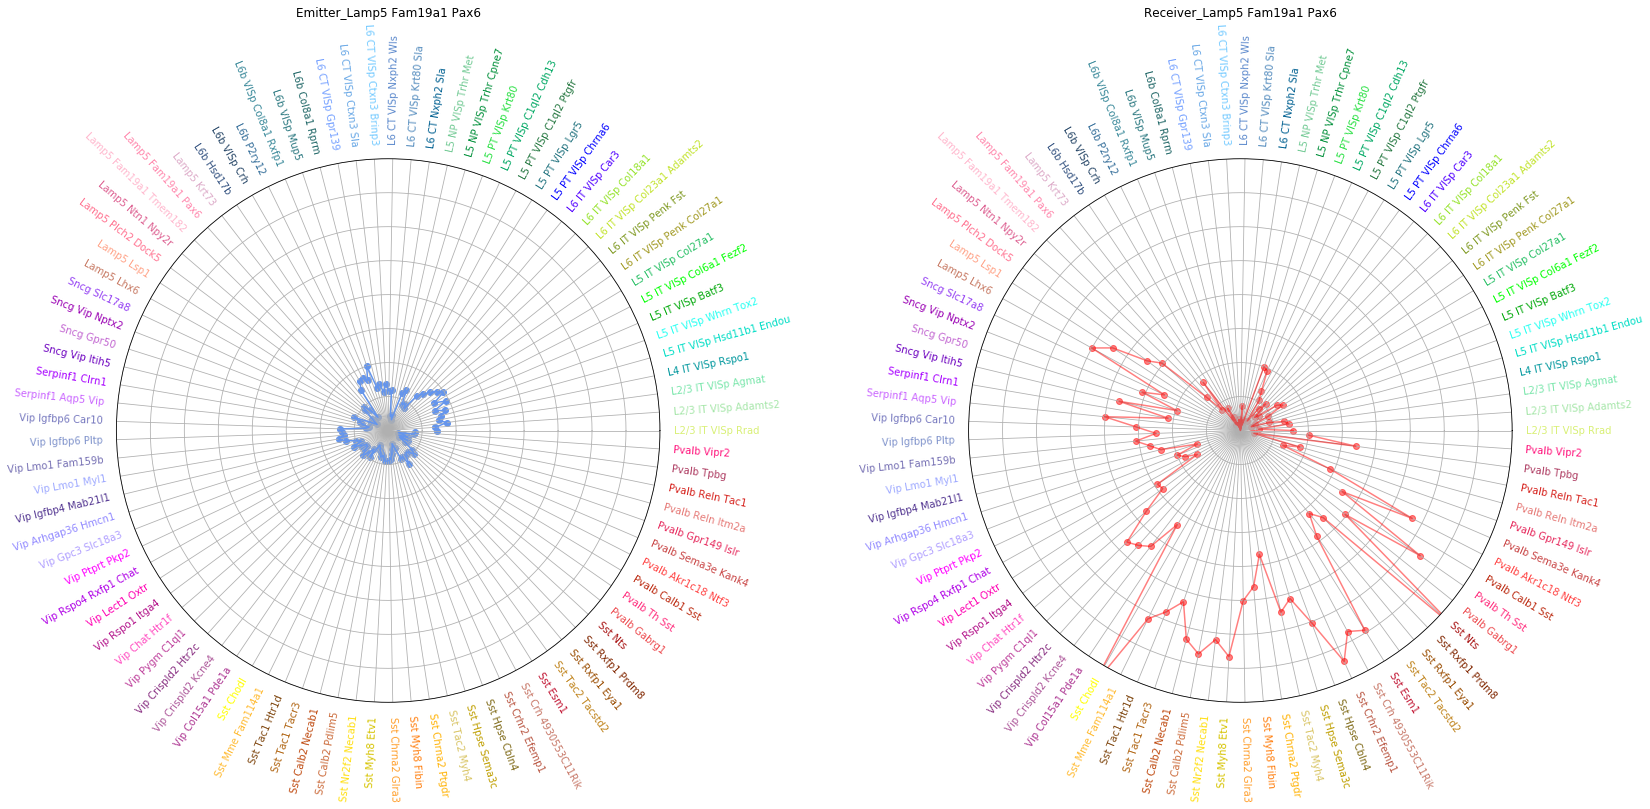

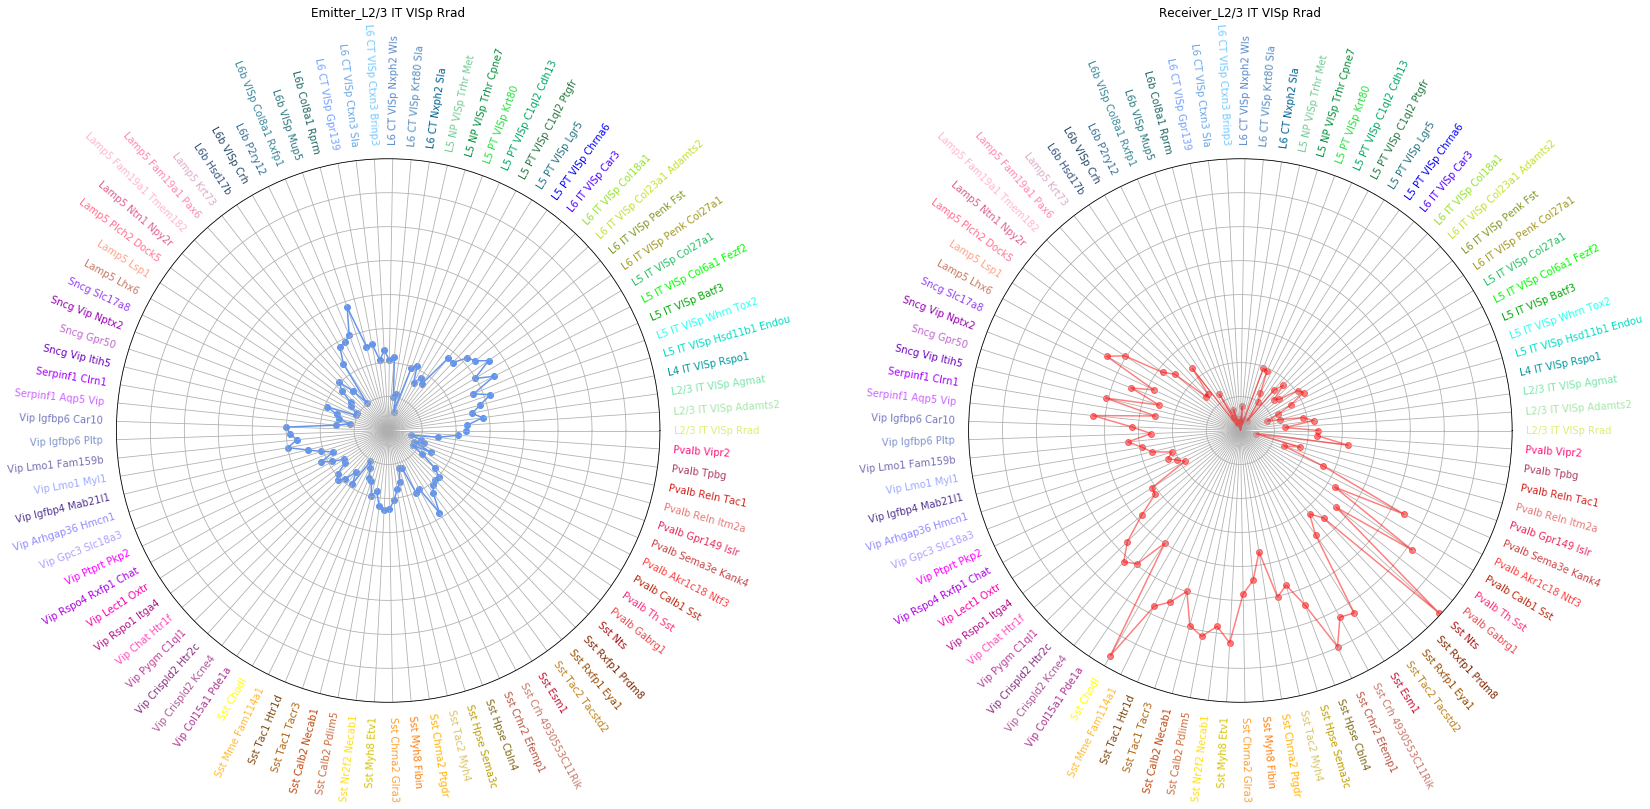

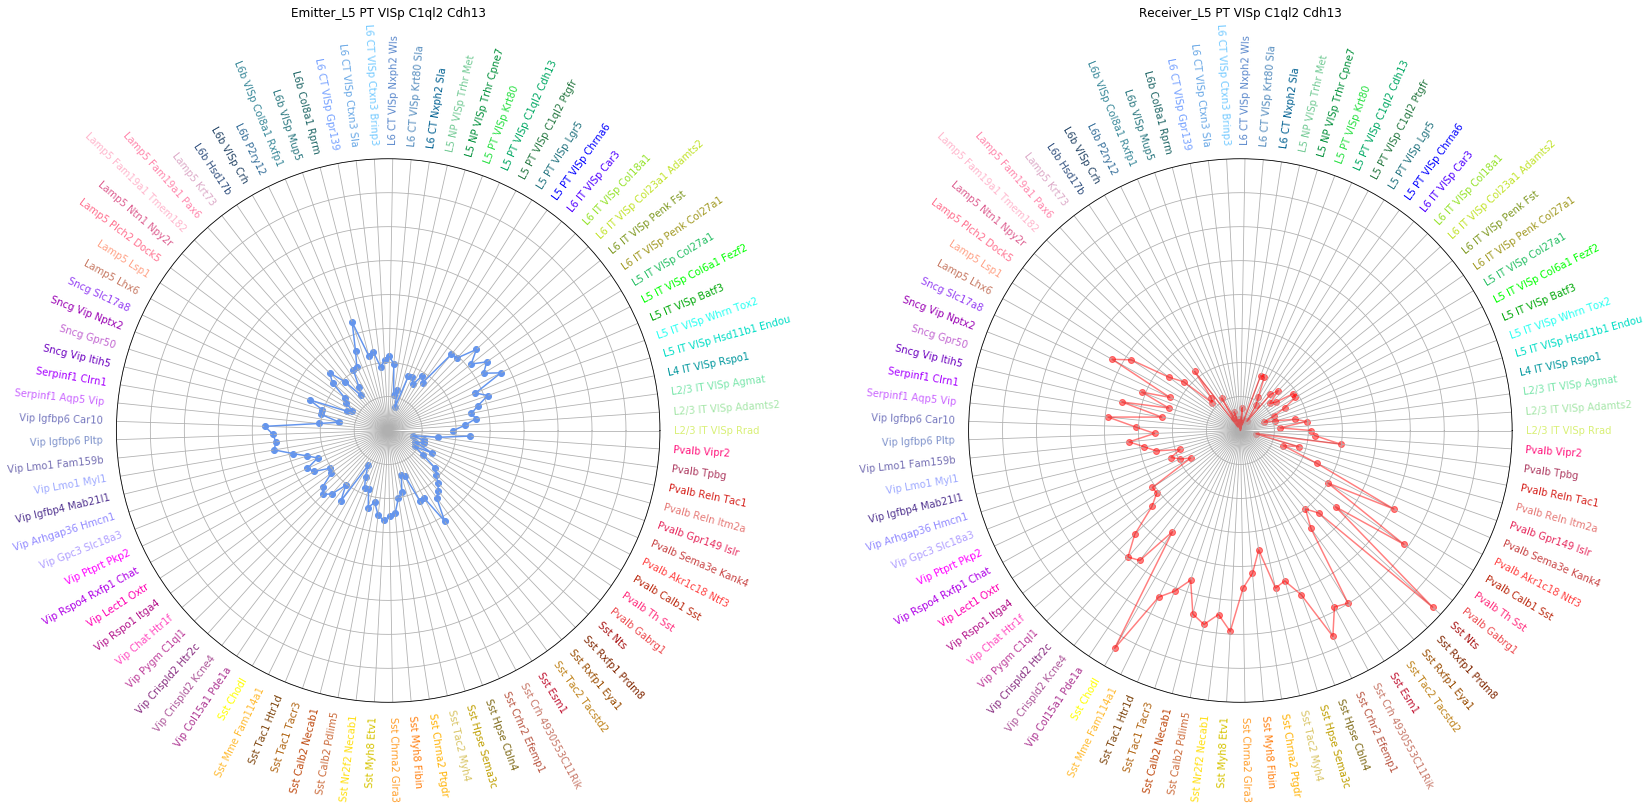

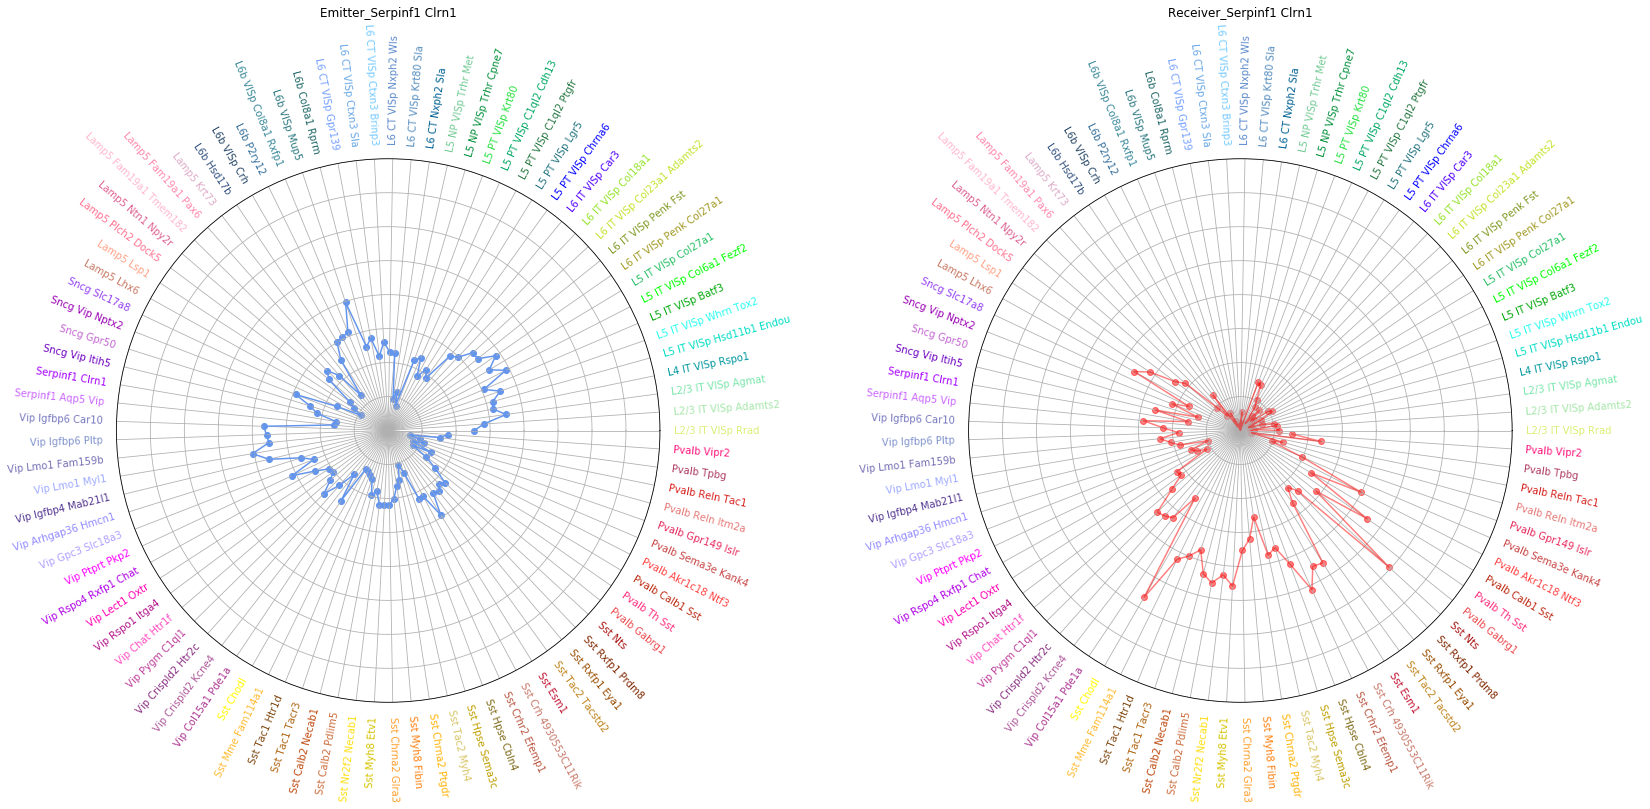

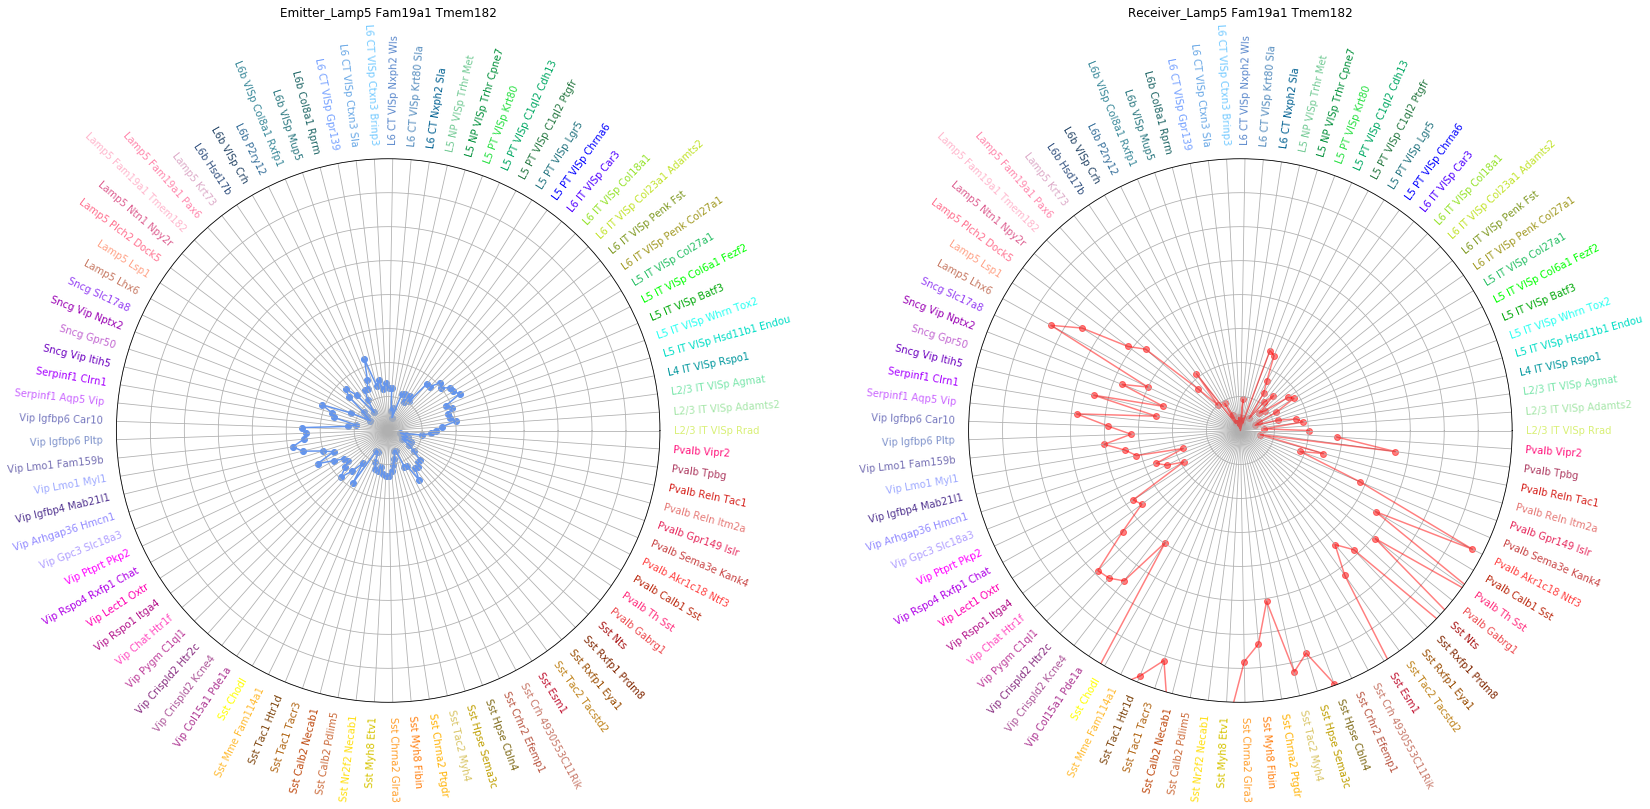

In [59]:
# for n in [20, 19, 87, 62]:
#     figname = types[n].replace("/", "")
#     figname = figname.replace(" ", "_") 
#     display(Image("/Users/fahimehb/Documents/NPP_GNN_project/dat/fig/" + figname + "_normal.png"))

for i in [34, 0, 17, 44, 35]:
    fig = plot_utils.plot_polar_source_target_relation(theta, 
                                                       r1=s_to_t[i], 
                                                       r2=t_to_s[i], 
                                                       title=types[i],
                                                       rmax = 0.08,
#                                                        rmax = 0.035,
                                                       xtick_label_colors=colors, 
                                                       xtick_labels=types,
                                                       plot_size=(28, 10))

In [149]:
context = torch.randn(2000, 1, 2)
target = torch.randn(2000, 1, 2)
# dist = context.unsqueeze(2) - target.unsqueeze(1)
# dist = c.reshape(2000, 11, 2)
# l2_norm_dist = torch.norm(dist, dim=2)

In [152]:
target[0]

tensor([[-0.6673,  1.4466]])

In [153]:
context[0]

tensor([[1.4004, 0.0790]])

In [160]:
context-target

tensor([[[ 2.0676, -1.3676]],

        [[ 1.0349, -0.9500]],

        [[-0.2852, -1.8763]],

        ...,

        [[ 1.7755,  2.0795]],

        [[ 1.6116,  0.3983]],

        [[ 0.5577,  3.1749]]])

In [170]:
torch.norm(context-target, dim=2)

tensor([[2.4790],
        [1.4048],
        [1.8978],
        ...,
        [2.7344],
        [1.6601],
        [3.2235]])

In [171]:
np.sqrt((0.5577)**2 + (3.1749)**2)**2

10.391019299999998